In [1]:
%reload_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
from M_Rod_Data_Generator import Data_Generator
import pysindy as ps
import scipy 
step_skip = 100
dt = 1.4e-4 * step_skip
M_Rod_Data = Data_Generator(end_time = 50, amplitude_period=20, direction_period=7,step_skip=step_skip) #size (tsize,dim,n_elem)

['/Users/hole/Files/Qubot/Codes/Qubot_Elastica/Qubot_Elastica/PyElastica_Playground/SINDY-MPC', '/Users/hole/anaconda3/envs/Qubot/lib/python310.zip', '/Users/hole/anaconda3/envs/Qubot/lib/python3.10', '/Users/hole/anaconda3/envs/Qubot/lib/python3.10/lib-dynload', '', '/Users/hole/anaconda3/envs/Qubot/lib/python3.10/site-packages', '/Users/hole/Files/Qubot/Codes/Qubot_Elastica/Qubot_Elastica/PyElastica_Playground']
pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


100%|██████████| 357143/357143 [00:48<00:00, 7354.01it/s]


In [5]:
#--------you have to modify Uniform_Magnetic_Rod's callback function first----
import os
from IPython.display import Video
from Plot_Method import plot_video_2D
normal = np.array([1.0,0.0,0.0])
current_dir = os.path.abspath("")
filename = current_dir + '/'+"Uniform_Magnetic_Rod.mp4"
x_lim = np.array([-2, 7.1])
y_lim = np.array([-6,6.1])
plot_video_2D(normal, x_lim, y_lim, M_Rod_Data, video_name=filename, fps=10, PLOT_VELOCITY=False, VELOCITY_SCALE=0.03)

Creating 2D video -- this can take a few minutes--------------------


In [3]:
for key,value in M_Rod_Data.items():
    if key != 'time' and key!='d':
        print(key)
        print(M_Rod_Data[key][0].shape)
    elif key == 'd':
        print(key)
        print(M_Rod_Data[key][0].shape)

position
(40, 2)
velocity
(40, 2)
omega
(40, 2)
d
(40, 4)
B_field
(40, 2)


In [4]:
tsize = len(M_Rod_Data['time'])
n_elem,n_dim = M_Rod_Data['velocity'][0].shape
Data_array = np.zeros((n_elem,tsize,6*n_dim))
ind = 0 # initialize index
for key,value in M_Rod_Data.items():
    if key != 'time' and key!='d':
        print(M_Rod_Data[key][0].shape)
        Data_array[:,:,ind:ind+2] = np.dstack(M_Rod_Data[key]).transpose([0,2,1])
        ind += 2
    elif key == 'd':
        print(M_Rod_Data[key][0].shape)
        Data_array[:,:,ind:ind+4] = np.dstack(M_Rod_Data[key]).transpose([0,2,1])
        ind += 4
spatial_grid = np.arange(40)
print(Data_array.shape,'shape: (n_elem,tsize,n_var)')
x = Data_array[:,:,0:10] #state variables
n_var = x.shape[-1]
u = Data_array[:,:,10:] #control variables
tspan = np.array(M_Rod_Data.pop('time'))

(40, 2)
(40, 2)
(40, 2)
(40, 4)
(40, 2)
(40, 3572, 12) shape: (n_elem,tsize,n_var)


In [6]:
import pysindy as ps
#-----hard to solve PDEs directly-------
x_dot = ps.FiniteDifference(axis=1)._differentiate(x, dt)
# polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
    lambda x:    x * x * x * x,
    lambda x, y: x * y * y * y,
    lambda x, y: x * x * y * y,
    lambda x, y: x * x * x * y,
    # lambda x:    x * x * x * x * x,
    # lambda x, y: x * y * y * y * y,
    # lambda x, y: x * x * y * y * y,
    # lambda x, y: x * x * x * y * y,
    # lambda x, y: x * x * x * x * y,
]
# library_functions = [
#     lambda x: x,
#     lambda x: x * x * x,
#     lambda x, y: x * y * y,
#     lambda x, y: x * x * y,
# ]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5,
                     normalize_columns=True, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(x=x, x_dot=x_dot, u = u)
model.print()

STLSQ model: 


: 

In [4]:
tsize = len(M_Rod_Data['time'])
n_elem,n_dim = M_Rod_Data['velocity'][0].shape
# reshape data into a numpy array
tspan = np.array(M_Rod_Data.pop('time'))
Data_array = np.concatenate(list(M_Rod_Data.values()),axis=0)
print(Data_array.shape)
# for key,value in M_Rod_Data.items():
#     if key != 'time':
#         M_Rod_Data[key] = (np.array(value).transpose([1,0,2])) 
print(len(M_Rod_Data))


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 2 and the array at index 3 has size 4

In [14]:
# reshape data into a numpy array
tspan = np.array(M_Rod_Data.pop('time'))
Data_array = np.concatenate(list(M_Rod_Data.values()),axis=0)
print(Data_array.shape)
np.save('Data_array.npy',Data_array)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 3 has 4 dimension(s)

In [59]:
# only using position values?
print(M_Rod_Data['position'].shape)
position_Data = M_Rod_Data['position']
print(position_Data.shape)
Data_array = position_Data

(123, 3572)
(123, 3572)


In [25]:
import numpy as np
Data_array = np.load("Data_array.npy")

In [5]:
x_dot = ps.FiniteDifference(axis=1)._differentiate(x, dt) #shape: n_elem, tsize, n_var
x_dot = x_dot.transpose([0,2,1]).reshape(n_elem*n_var,tsize) #shape: n_elem*tsize, n_var
x = x.transpose([0,2,1]).reshape(n_elem*n_var,tsize) # state vectors: origin shape (n_elem, tsize, n_var) shape: n_elem*n_var, tsize
U, S, V = scipy.linalg.svd(x)
u = u[0] # shape tsize, control_features
print(u.shape)


(3572, 2)


In [21]:
print(V[4])

[ 0.00032445  0.00037368  0.00066069 ... -0.0019844  -0.00189277
 -0.00192448]


In [10]:
print(V.shape,U.shape)

(3572, 3572) (400, 400)


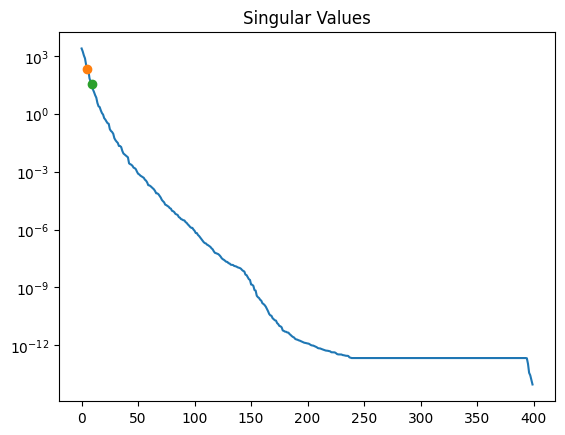

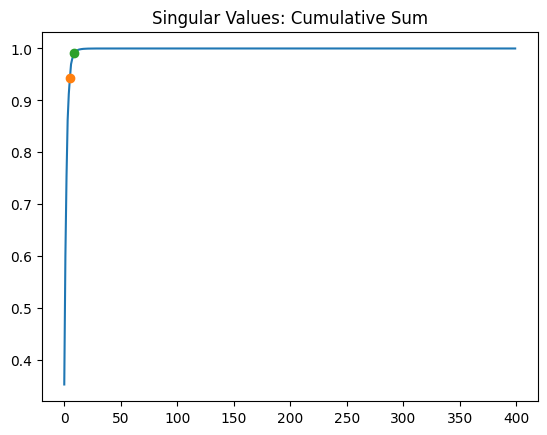

Cumulation contribution [0.35282271 0.60028882 0.75434874 0.86265125 0.9123167  0.9433887
 0.96979096 0.97971611 0.9861667  0.99098631]


In [6]:
import matplotlib.pyplot as plt
## f_ch01_ex02_2

plt.figure(1)
plt.semilogy(S)
plt.plot(5,S[5],'o')
plt.plot(9,S[9],'o')
plt.title('Singular Values')
plt.show()

plt.figure(2)
Cum= np.cumsum(S)/np.sum(S)
plt.plot(Cum)
plt.plot(5,Cum[5],'o')
plt.plot(9,Cum[9],'o')
plt.title('Singular Values: Cumulative Sum')
plt.show()

print('Cumulation contribution', Cum[:10])

In [7]:
polyorder = 5 
r = 6 # Truncate the first 6 modes
Ur = U[:,:r] # each col is the mode we focused on
New_var = (Ur.T @ x).T # shape: (tsize,r)
print(New_var[:,0])

[ 0.02604005  0.01367592 -0.06957811 ...  6.67773761  6.35847575
  6.07830042]


In [41]:
print(S[:r],Vr[:,2],V[2])

[2501.98885851 1754.86849974 1092.49263848  768.01084525  352.19505037
  220.34233925] [23.92196149 23.92199829 23.92238542 ... 23.94363919 23.93530315
 23.92617983] [0.02189668 0.02189671 0.02189707 ... 0.02191652 0.02190889 0.02190054]


In [10]:
import pysindy as ps
polyorder = 5 
r = 6 # Truncate the first 6 modes
Vr = V[:r,:].T # each col is the individual mode data varying by time
x_library_functions = [lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
]
x_dot_library_functions = [lambda x: x, lambda x,y:x*y, lambda x: x**2]


# Need to pass time base to the library
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=tspan,
    include_bias=True,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    max_iter=20000,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(Vr,t=tspan)
model.print()

Model  0
Solver failed on model  0 , setting coefs to zeros
Model  1


/Users/hole/anaconda3/envs/Qubot/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Model  13
Model  14
Model  15
Model  16
Model  17
Model  18
Solver interrupted


ValueError: OSQP solve error!

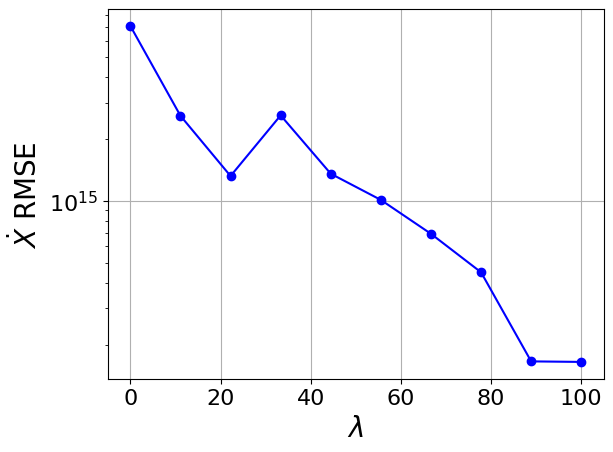

In [15]:
# ----find the best threshold-----
import pysindy as ps
from sklearn.metrics import mean_squared_error
from utilts import plot_pareto
train_time = 3000
V_train = New_var[:train_time,:]
V_test = New_var[train_time:,:]
t_test = tspan[:tsize-train_time]
u_train = u[:train_time]
u_test = u[:tsize-train_time]
poly_order = 5
threshold_scan = np.linspace(0, 100, 10)
coefs = []
# Initialize three libraries
poly_library = ps.PolynomialLibrary(degree=poly_order)
# fourier_library = ps.FourierLibrary(n_frequencies=3)
# library_functions = [lambda x: 1.0 / (x), lambda x: np.exp(-x)]

# tensor_array = [[1, 1]]

# # Initialize this generalized library, all the work hidden from the user!
# library = ps.GeneralizedLibrary(
#     [poly_library, fourier_library],
#     tensor_array=tensor_array,
# )
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold,normalize_columns=True)
    model = ps.SINDy(feature_library=poly_library,
                     optimizer=sparse_regression_optimizer)
    model.fit(V_train, t=dt, u= u_train, quiet=True)
    coefs.append(model.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model, 
            threshold_scan, V_test, t_test, u_test)

In [13]:
import pysindy as ps
#--------SINDY learn the model--------
poly_order = 5
threshold = 50
# Initialize three libraries
poly_library = ps.PolynomialLibrary(degree=poly_order)
fourier_library = ps.FourierLibrary(n_frequencies=2)
library_functions = [lambda x: 1.0 / (x), lambda x: np.exp(-x)]

tensor_array = [[1, 1]]

# Initialize this generalized library, all the work hidden from the user!
library = ps.GeneralizedLibrary(
    [poly_library, fourier_library],
    tensor_array=tensor_array,
)

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, normalize_columns=True),
    feature_library=library,
)
model.fit(New_var, t=dt, u = u)
model.print()

(x0)' = 0.001 x0 x1^3 + 0.001 x1^3 u1 + -0.001 x1 u0^2 u1 + 0.002 x0^2 x2^2 u1 + 0.001 x0^2 x2 x3 u1 + -0.001 x0^2 x2 u0 u1 + 0.001 x0^2 x3^3 + -0.001 x0^2 x3 u0 u1 + -0.001 x0 x1 x2^3 + -0.001 x0 x1 x2^2 x3 + 0.001 x0 x1 x2^2 u0 + 0.002 x0 x1 x2^2 u1 + 0.001 x0 x1 x2 x3 u1 + -0.001 x0 x1 x2 u0^2 + -0.001 x0 x1 x2 u1^2 + -0.001 x0 x1 x3 x4^2 + -0.001 x0 x1 x3 x4 u0 + 0.001 x0 x1 x3 u0^2 + 0.001 x0 x2^3 x4 + -0.001 x0 x2^3 x5 + 0.001 x0 x2^3 u1 + 0.001 x0 x2^2 x3^2 + 0.001 x0 x2^2 x4 u0 + -0.001 x0 x2^2 u1^2 + 0.001 x0 x2 x3^2 u0 + 0.001 x0 x2 x3 u0^2 + 0.001 x0 x3^3 u1 + -0.001 x0 x3^2 u1^2 + 0.001 x0 x3 u0 u1^2 + -0.001 x1^2 x2^3 + 0.001 x1^2 x2 x3 u0 + -0.001 x1^2 x2 x3 u1 + 0.001 x1^2 x3^3 + -0.001 x1^2 x3 u0^2 + -0.001 x1^2 x3 u0 u1 + -0.001 x1 x2^3 x3 + -0.002 x1 x2 u0 u1^2 + 0.001 x1 x3 x5 u1^2 + -0.001 x1 x3 u0 u1^2 + -0.001 x1 x3 u1^3 + 0.001 x2^3 x3 u0 + 0.001 x2^3 x3 u1 + 0.001 x2^3 x4 u0 + -0.001 x2^3 u1^2 + 0.001 x2^2 x3^2 u0 + 0.001 x2^2 x3^2 u1 + -0.001 x2^2 x3 u0^2 + -0.